In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML
from animations import TrajectoryAnimation3D
import warnings

from optimizers import SGD, Adagrad, Adadelta, RMSProp, Adam, AdaMax 

matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['animation.ffmpeg_path'] = "/usr/bin/ffmpeg"
warnings.simplefilter('ignore')

In [25]:
def optimize(func, grad_func, optimizer, n_iter=100000, epsilon=1e-6):

    params = func.initial
    opt_path = []
    old_loss = 0.0
    
    for it in range(n_iter):
        
        loss = func(*params)
        
        if np.abs(loss - old_loss) <= epsilon:
            print(optimizer,"stopped in %d iterations" % it)
            break

        opt_path.append(params)
        grad_params = grad_func(*params)
        params = optimizer.step(params, grad_params)
        old_loss = loss
        
    return params, np.array(opt_path)

In [26]:
from functions import Himmelblau, Booth, Beale, Saddle,CamelBack
from function_configs import HIMMELBLAU_CONFIG, BOOTH_CONFIG, BEALE_CONFIG, SADDLE_CONFIG, CAMELBACK_CONFIG

def create_function(name):
    if name == "Himmelblau":
        function_config = HIMMELBLAU_CONFIG
        function = Himmelblau(**function_config)
    elif name == "Saddle":
        function_config = SADDLE_CONFIG
        function = Saddle(**function_config)    
    elif name == "Booth":
        function_config = BOOTH_CONFIG
        function = Booth(**function_config)
    elif name == "CamelBack":
        function_config = CAMELBACK_CONFIG
        function = CamelBack(**function_config)
    elif name == "Beale":
        function_config = BEALE_CONFIG
        function = Beale(**function_config)
    else:
        raise ValueError("Function name not recognized")


    function.x, function.y = np.meshgrid(np.arange(function.xmin, function.xmax + function.step, function.step), np.arange(function.ymin, function.ymax + function.step, function.step))
    function.z = function(function.x, function.y)

    return function

In [27]:
def sample_path(path, total_sample=100):
    path_len = len(path)

    if total_sample==0:
        return np.vstack((path[0],path[len(path)//2],path[-1]))
    
    print("sample computed for path_len=%d is %d" % (path_len,total_sample))

    increment = path_len//total_sample    

    return np.vstack((path[::increment], path[-1]))

In [28]:
def concatenate_name_steps(methods,steps):
    return [m + " (steps: "+str(s)+")" for m, s in zip(methods, steps)]

In [29]:
def draw_2d(function,methods,sampled_paths,file_name):
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Booth Function', fontsize=20)

    for i, (method, path) in enumerate(zip(methods, sampled_paths)):
        
        ax = fig.add_subplot(2, 3, i+1)
        ax.contour(function.x, function.y, function.z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
        ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], 
                scale_units='xy', angles='xy', scale=0.25) 
        ax.plot(function.minima[:, 0], function.minima[:, 1], 'r*', markersize=18)

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')

        ax.set_xlim((function.xmin, function.xmax))
        ax.set_ylim((function.ymin, function.ymax))
        ax.set_title(method)
        
    plt.savefig(file_name)

In [39]:
from matplotlib.animation import PillowWriter

def draw_3d(function, sampled_paths, zpaths, methods, steps, file_name, gif):
        fig = plt.figure(figsize=(12, 8))

        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.plot_surface(function.x, function.y, function.z, rstride=1, cstride=1, edgecolor='none', norm=LogNorm(),
                        alpha=0.7, cmap=plt.cm.jet, zorder=0)

        ax.scatter3D(function.minima[:, 0], function.minima[:, 1], 
                function(function.minima[:, 0], function.minima[:, 1]).reshape(-1, 1), 
                c='black', marker='*', s=60, zorder=5)
        initial=np.array(function.initial)
        ax.plot(*np.array(initial).reshape(-1, 1), function(*initial), c='b', 
                marker='o', markersize=10, zorder=5)

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')

        ax.set_xlim((function.xmin, function.xmax))
        ax.set_ylim((function.ymin, function.ymax))

        #ax.set_title("Booth Function", fontdict={"fontsize": 20})
        ax.view_init(elev=45, azim=45)

        anim = TrajectoryAnimation3D(*sampled_paths, zpaths=zpaths, labels=concatenate_name_steps(methods,steps), fig=fig, ax=ax)
        ax.legend(loc='upper right')
        if gif:
                anim.save(file_name, writer=PillowWriter(fps=10),)
        else:
                anim.save(file_name, fps=30)

In [31]:
def run(methods, function, optimizers, max_samples, max_iter, filename_2d, filename_3d, gif=True):
    all_end_values = []
    all_opt_paths = []

    for optimizer in optimizers:
        end_values, opt_path = optimize(function, function.grad, optimizer,n_iter=max_iter)
        all_end_values.append(end_values)
        all_opt_paths.append(opt_path)
        
    steps = [len(path) for path in all_opt_paths]
    print("Steps",concatenate_name_steps(methods,steps))
    #Resampling. Get the number of samples
    steps_sampled = []
    for s in steps:
        factor = max(steps)//max_samples
        if factor==0:
            factor=1
        steps_sampled.append(s//factor)
        
    sampled_paths = [sample_path(path, total_sample=s) 
                 for path,s in zip(all_opt_paths,steps_sampled)]
    len_sample_paths = [len(path) for path in sampled_paths]
    print("len_sample_paths", len_sample_paths)
    sampled_paths = [path.T for path in sampled_paths]
    zpaths = [function(*path) for path in sampled_paths]
    draw_2d(function,methods,sampled_paths,filename_2d)
    draw_3d(function,sampled_paths,zpaths,methods,steps,filename_3d, gif)

In [32]:
from PIL import Image
def gif_to_png(gif_file, png_file):
    # Open the GIF file
    gif = Image.open(gif_file)

    # Extract frames from the GIF
    frames = []
    try:
        while True:
            frame = gif.copy()
            frames.append(frame)
            gif.seek(len(frames))  # Move to the next frame
    except EOFError:
        pass

    # Calculate indices for the first, middle, and last frames
    num_frames = len(frames)
    first_index = 0
    middle_index = num_frames // 2
    last_index = num_frames - 1

    # Crop each frame to remove margins
    cropped_frames = []
    bbox = (100, 50, 550, 460)
    for frame in (frames[first_index], frames[middle_index], frames[last_index]):
        cropped_frame = frame.crop(bbox)
        cropped_frames.append(cropped_frame)

    # Calculate the width and height of the cropped frames
    width = max(frame.width for frame in cropped_frames)
    height = max(frame.height for frame in cropped_frames)

    # Resize each frame to a third of the final width
    resized_frames = [
        frame.resize((width, height), Image.ANTIALIAS)
        for frame in cropped_frames
    ]

    # Create a new image with the combined frames
    thumbnail_width = width * 3
    thumbnail_height = height
    thumbnail = Image.new('RGBA', (thumbnail_width, thumbnail_height))

    # Paste the frames onto the thumbnail image
    x_offset = 0
    for frame in resized_frames:
        thumbnail.paste(frame, (x_offset, 0))
        x_offset += width

    # Save the thumbnail as a PNG file
    thumbnail.save(png_file, 'PNG')

    # Display the PNG image
    display(Image.open(png_file))


#### Comparación entre SGD y SGD con momento.

<optimizers.SGD object at 0x7f5a4f783730> stopped in 2857 iterations
<optimizers.SGD object at 0x7f5a4f780550> stopped in 277 iterations
Steps ['SGD (steps: 2857)', 'SGD (momentum) (steps: 277)']
sample computed for path_len=2857 is 20
sample computed for path_len=277 is 1
len_sample_paths [22, 2]
<optimizers.SGD object at 0x7f5a4f783730> stopped in 337 iterations
<optimizers.SGD object at 0x7f5a4f780550> stopped in 152 iterations
Steps ['SGD (steps: 337)', 'SGD (momentum) (steps: 152)']
sample computed for path_len=337 is 21
sample computed for path_len=152 is 9
len_sample_paths [23, 11]


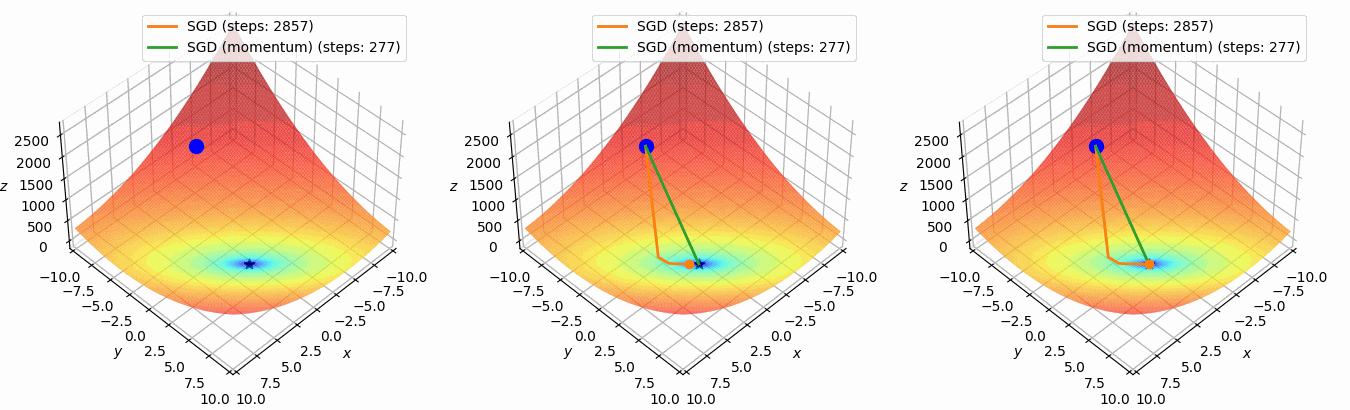

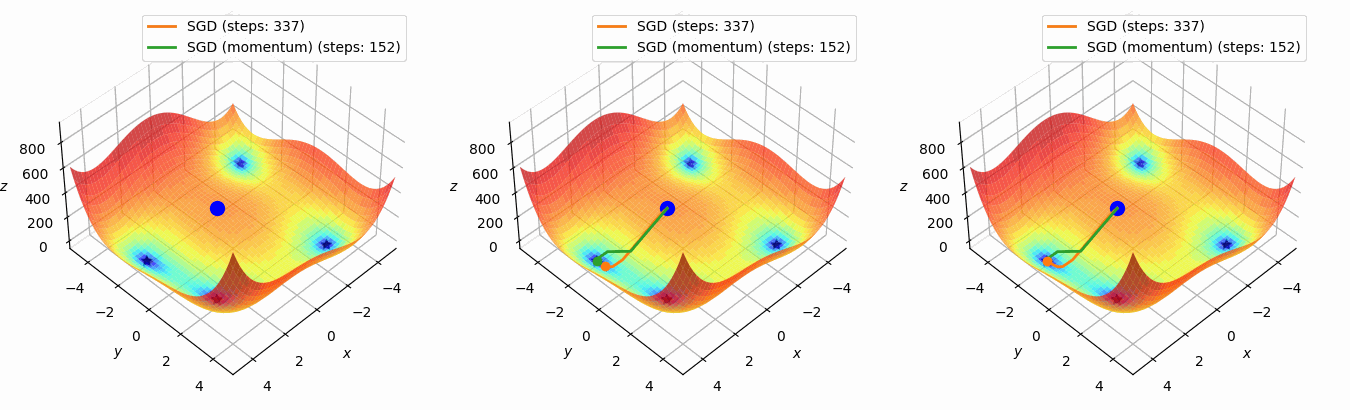

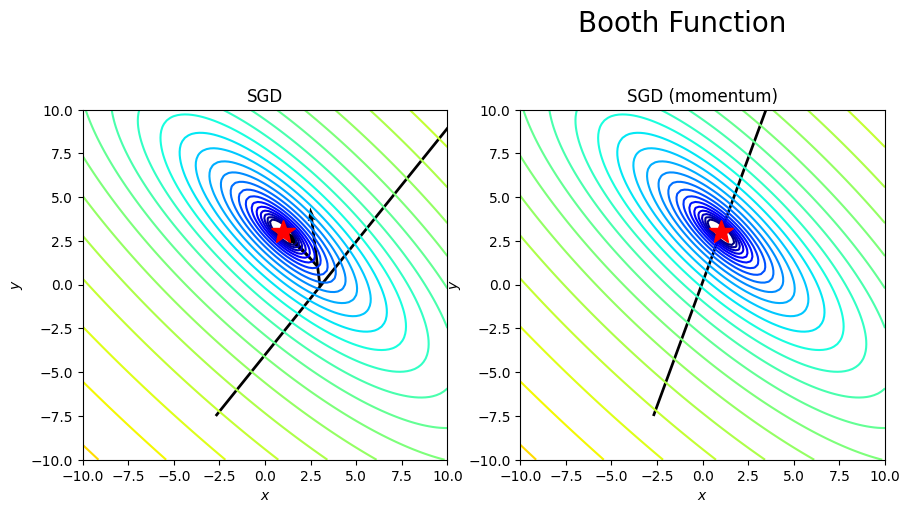

<Figure size 1200x800 with 0 Axes>

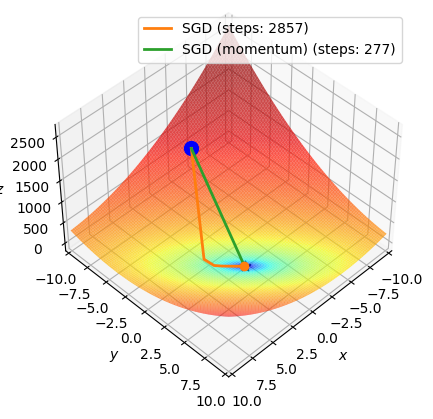

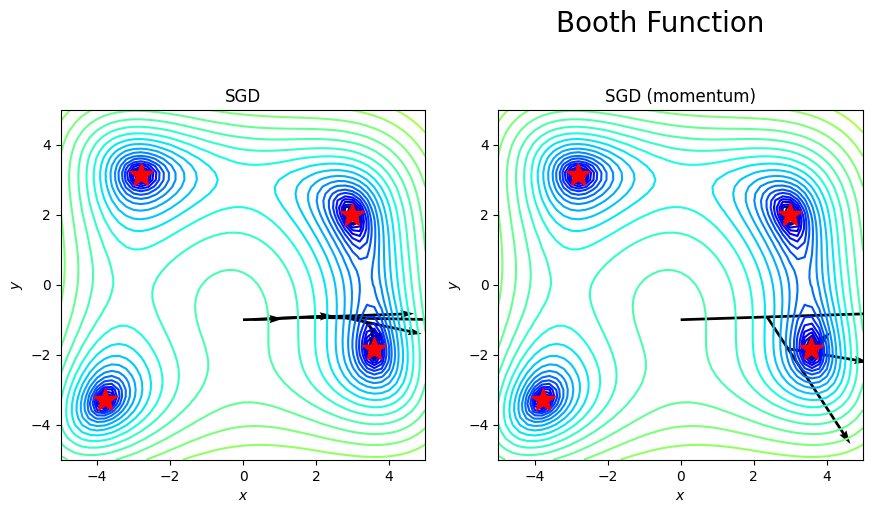

<Figure size 1200x800 with 0 Axes>

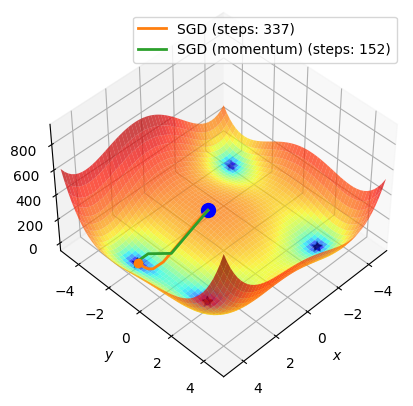

In [33]:
# Implemented methods: 'SGD', 'Adagrad', 'Adadelta', 'RMSProp', 'Adam', 'AdaMax'
methods = ['SGD','SGD (momentum)']
optimizers = [
    SGD(lr=0.001),
    SGD(lr=0.001,momentum=0.9)
]

# Functions: Beale, Booth, Himmelblau, CamelBack, Saddle
function1 = create_function('Booth')
function2 = create_function('Himmelblau')
max_iter=20000
max_samples_draw = 20

run(methods, function1, optimizers, max_samples_draw, max_iter, "output/sgdvssgdm2d_f1.png","output/sgdvssgdm3d_f1.gif")
run(methods, function2, optimizers, max_samples_draw, max_iter, "output/sgdvssgdm2d_f2.png","output/sgdvssgdm3d_f2.gif")
gif_to_png("output/sgdvssgdm3d_f1.gif","../../../imgs/tema3/sgdvssgdm_f1.png")
gif_to_png("output/sgdvssgdm3d_f2.gif","../../../imgs/tema3/sgdvssgdm_f2.png")


<optimizers.SGD object at 0x7f5a57cd44c0> stopped in 2857 iterations
Steps ['SGD (steps: 2857)', 'Adagrad (steps: 20000)']
sample computed for path_len=2857 is 2
sample computed for path_len=20000 is 20
len_sample_paths [4, 21]
<optimizers.SGD object at 0x7f5a57cd44c0> stopped in 337 iterations
<optimizers.Adagrad object at 0x7f5a4db87c10> stopped in 7418 iterations
Steps ['SGD (steps: 337)', 'Adagrad (steps: 7418)']
sample computed for path_len=7418 is 20
len_sample_paths [3, 22]


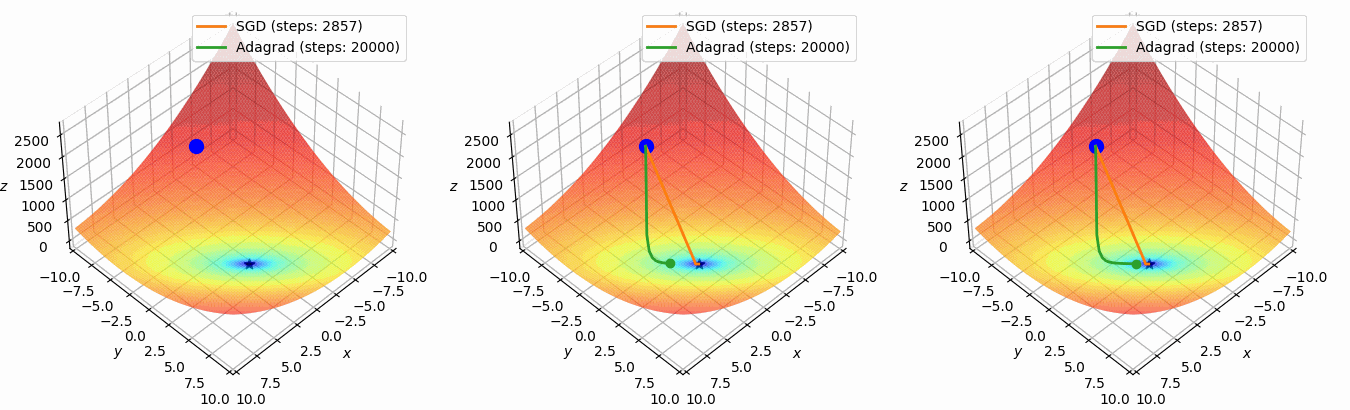

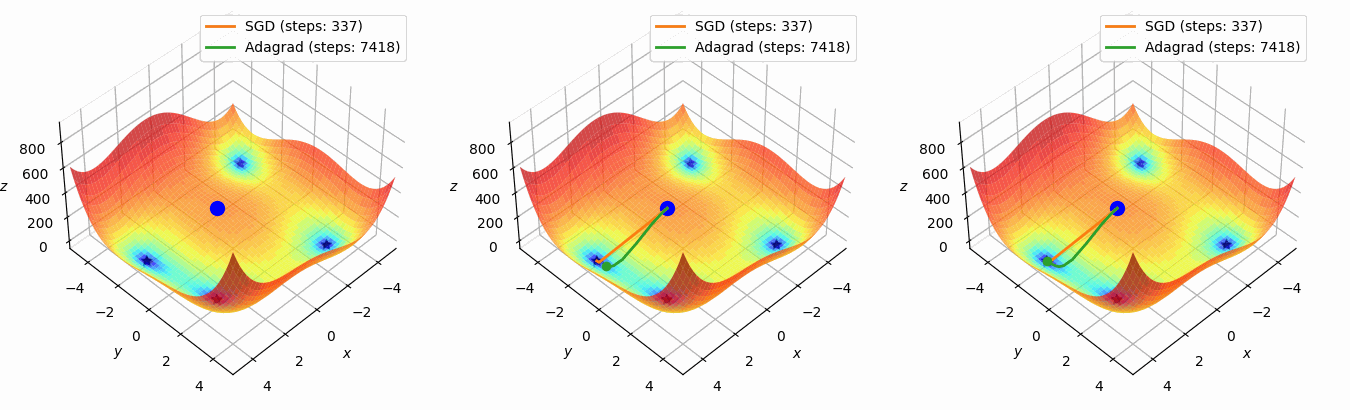

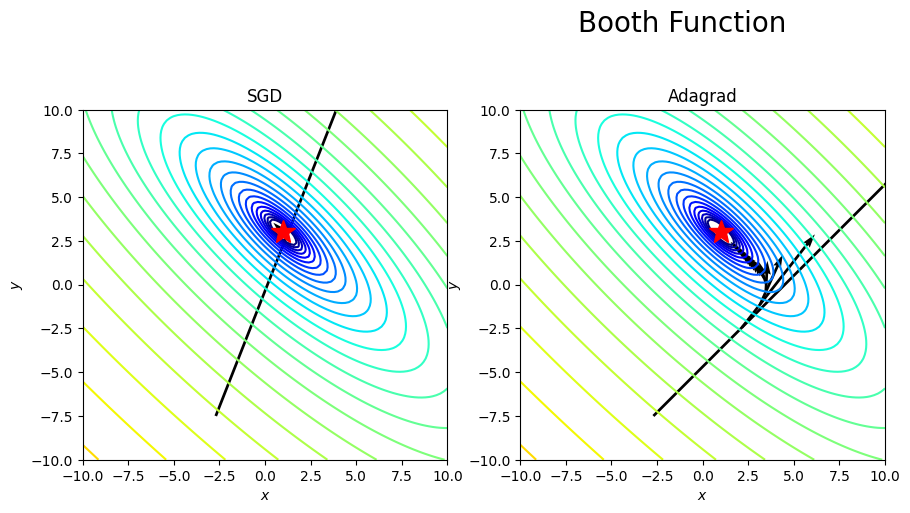

<Figure size 1200x800 with 0 Axes>

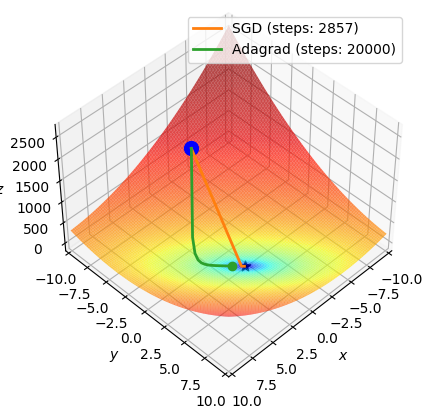

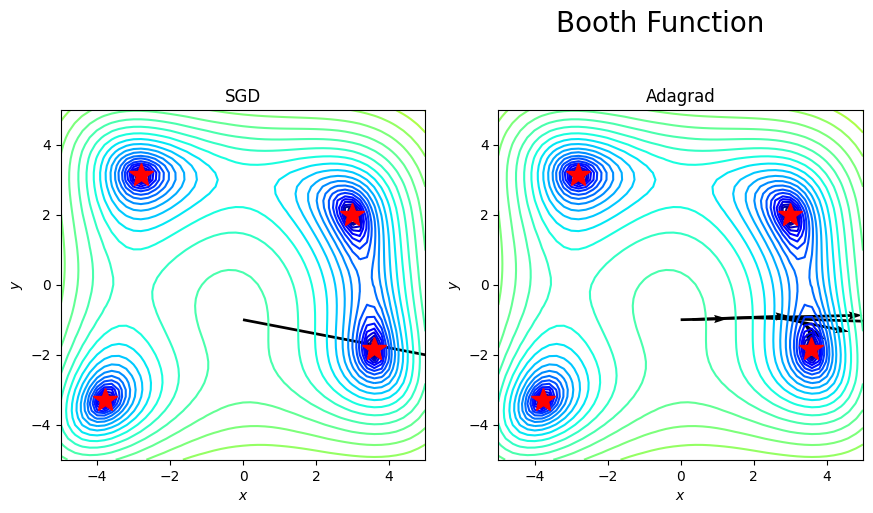

<Figure size 1200x800 with 0 Axes>

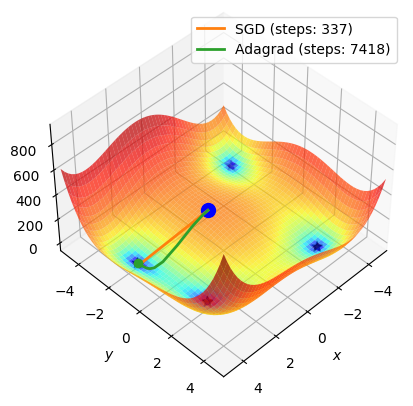

In [34]:
methods = ['SGD','Adagrad']
optimizers = [
    SGD(lr=0.001),
    Adagrad(lr=0.1),
]

# Functions: Beale, Booth, Himmelblau, CamelBack, Saddle
function1 = create_function('Booth')
function2 = create_function('Himmelblau')
max_iter=20000
max_samples_draw = 20

run(methods, function1, optimizers, max_samples_draw, max_iter, "output/sgdvsadagrad2d_f1.png","output/sgdvsadagrad3d_f1.gif")
run(methods, function2, optimizers, max_samples_draw, max_iter, "output/sgdvsadagrad2d_f2.png","output/sgdvsadagrad3d_f2.gif")
gif_to_png("output/sgdvsadagrad3d_f1.gif","../../../imgs/tema3/sgdvsadagrad_f1.png")
gif_to_png("output/sgdvsadagrad3d_f2.gif","../../../imgs/tema3/sgdvsadagrad_f2.png")

#### Comparación entre AdaGrad y RMSProp

<optimizers.RMSProp object at 0x7f5a5692f400> stopped in 163 iterations
Steps ['AdaGrad (steps: 20000)', 'RMSProp (steps: 163)']
sample computed for path_len=20000 is 20
len_sample_paths [21, 3]
<optimizers.Adagrad object at 0x7f5a566560b0> stopped in 7418 iterations
<optimizers.RMSProp object at 0x7f5a5692f400> stopped in 42 iterations
Steps ['AdaGrad (steps: 7418)', 'RMSProp (steps: 42)']
sample computed for path_len=7418 is 20
len_sample_paths [22, 3]


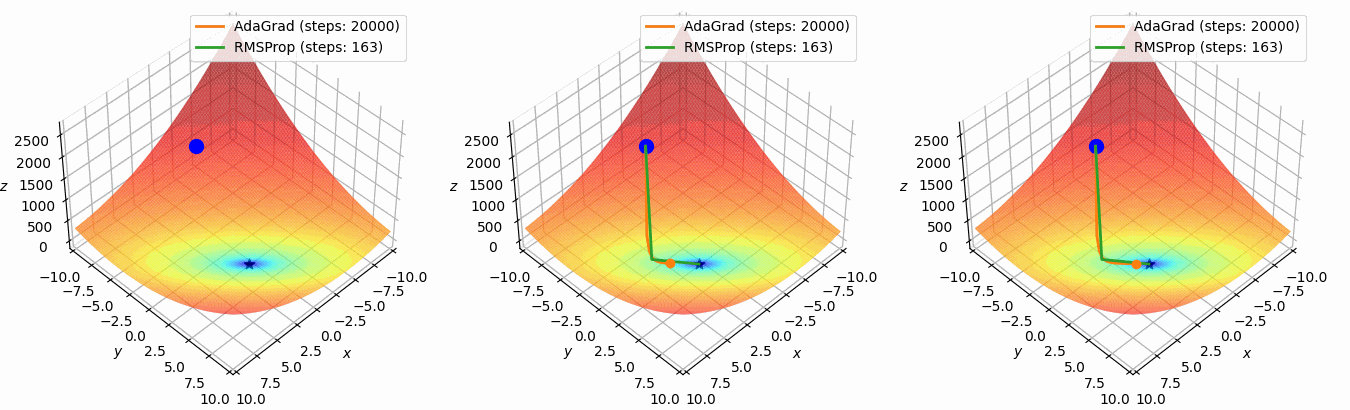

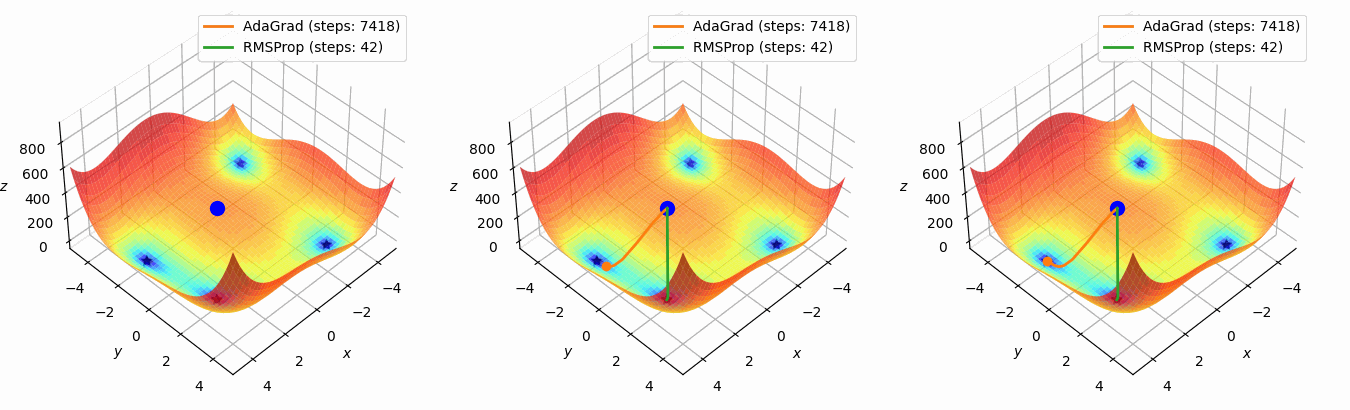

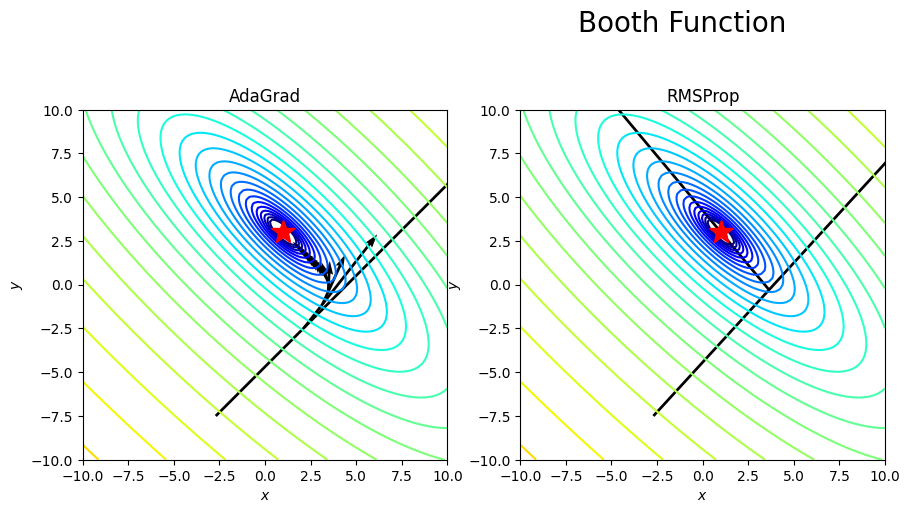

<Figure size 1200x800 with 0 Axes>

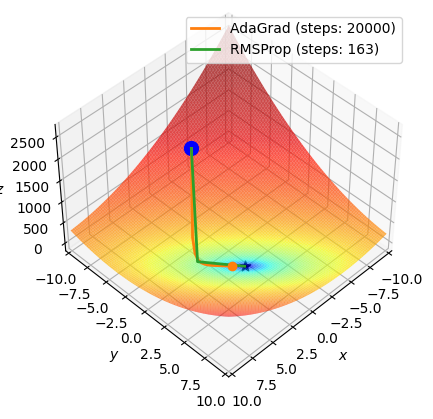

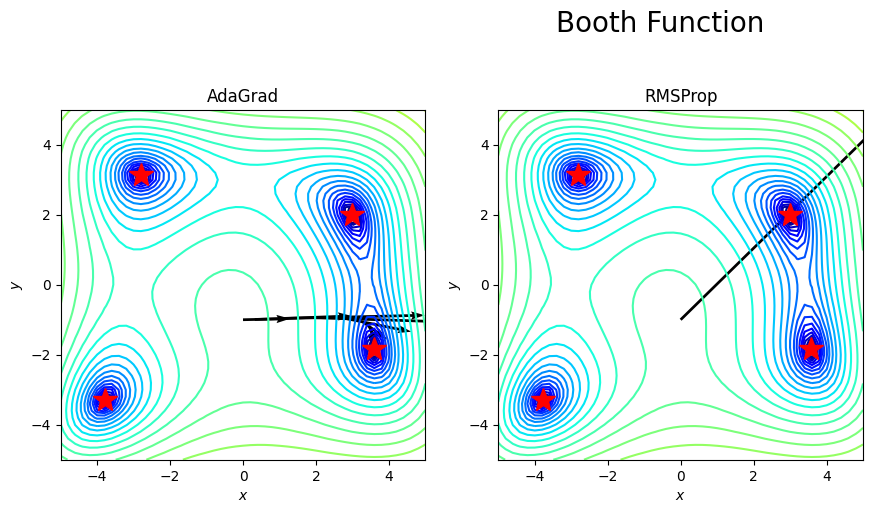

<Figure size 1200x800 with 0 Axes>

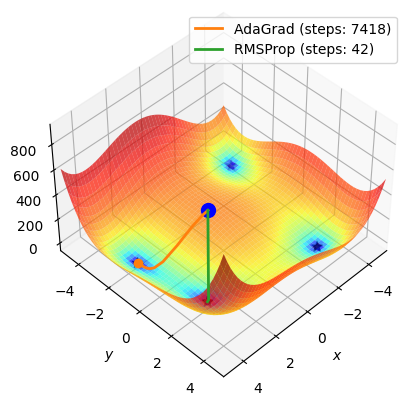

In [35]:
methods = ['AdaGrad','RMSProp']
optimizers = [
    Adagrad(lr=0.1),
    RMSProp(lr=0.1),
]
function1 = create_function('Booth')
function2 = create_function('Himmelblau')
max_iter=20000
max_samples_draw = 20

run(methods, function1, optimizers, max_samples_draw, max_iter, "output/adagradvsrmsprop2d_f1.png","output/adagradvsrmsprop3d_f1.gif")
run(methods, function2, optimizers, max_samples_draw, max_iter, "output/adagradvsrmsprop2d_f2.png","output/adagradvsrmsprop3d_f2.gif")
gif_to_png("output/adagradvsrmsprop3d_f1.gif","../../../imgs/tema3/adagradvsrmsprop_f1.png")
gif_to_png("output/adagradvsrmsprop3d_f2.gif","../../../imgs/tema3/adagradvsrmsprop_f2.png")

<optimizers.RMSProp object at 0x7f5a5692ee30> stopped in 212 iterations
<optimizers.RMSProp object at 0x7f5a56f57c40> stopped in 163 iterations
<optimizers.RMSProp object at 0x7f5a4db84220> stopped in 388 iterations
Steps ['RMSProp0.8 (steps: 212)', 'RMSProp0.9 (steps: 163)', 'RMSProp0.99 (steps: 388)']
sample computed for path_len=212 is 30
sample computed for path_len=163 is 23
sample computed for path_len=388 is 55
len_sample_paths [32, 25, 57]
<optimizers.RMSProp object at 0x7f5a5692ee30> stopped in 40 iterations
<optimizers.RMSProp object at 0x7f5a56f57c40> stopped in 42 iterations
<optimizers.RMSProp object at 0x7f5a4db84220> stopped in 20 iterations
Steps ['RMSProp0.8 (steps: 40)', 'RMSProp0.9 (steps: 42)', 'RMSProp0.99 (steps: 20)']
sample computed for path_len=40 is 40
sample computed for path_len=42 is 42
sample computed for path_len=20 is 20
len_sample_paths [41, 43, 21]


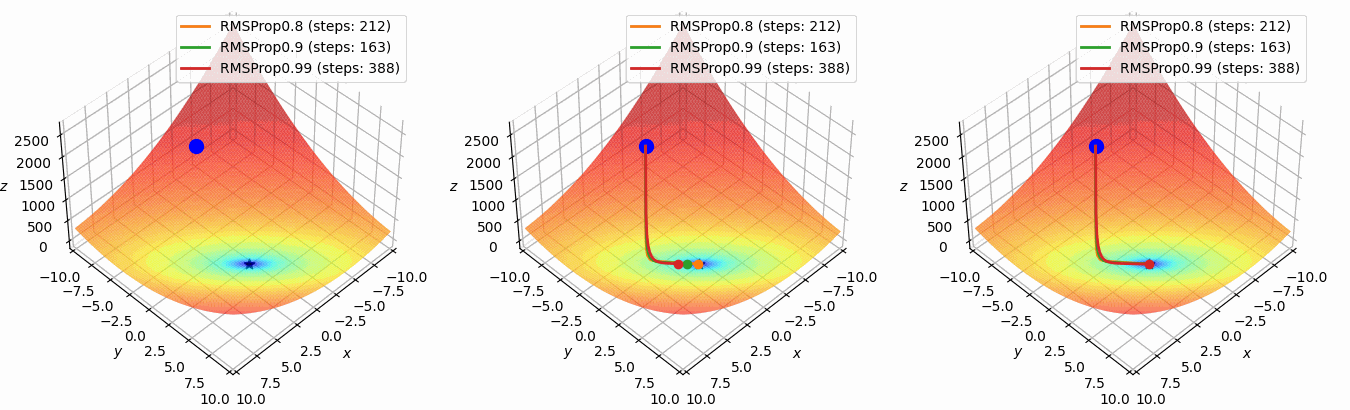

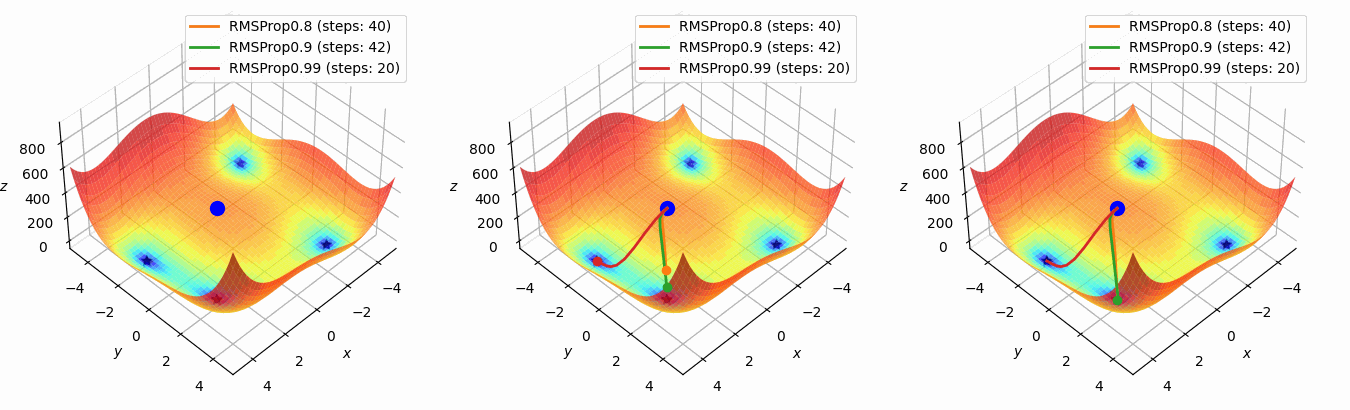

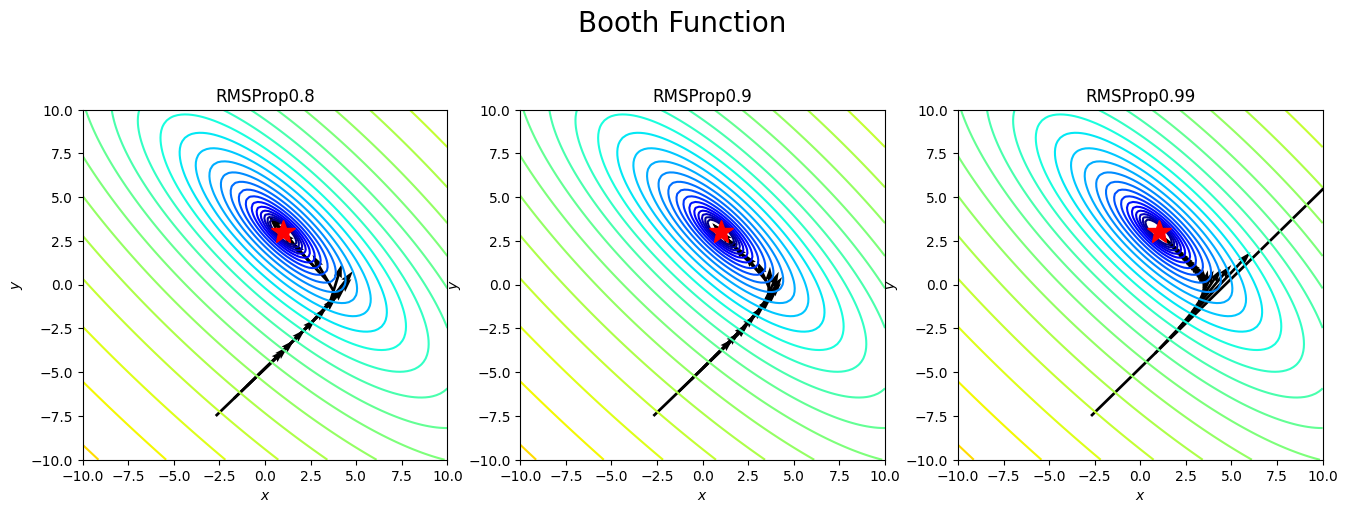

<Figure size 1200x800 with 0 Axes>

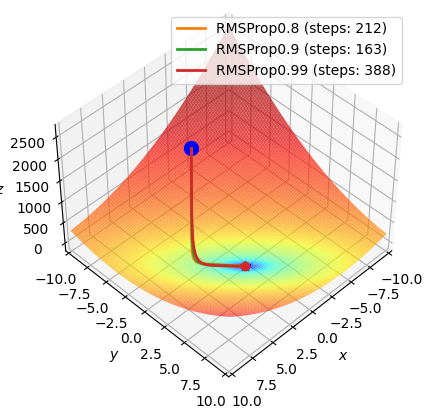

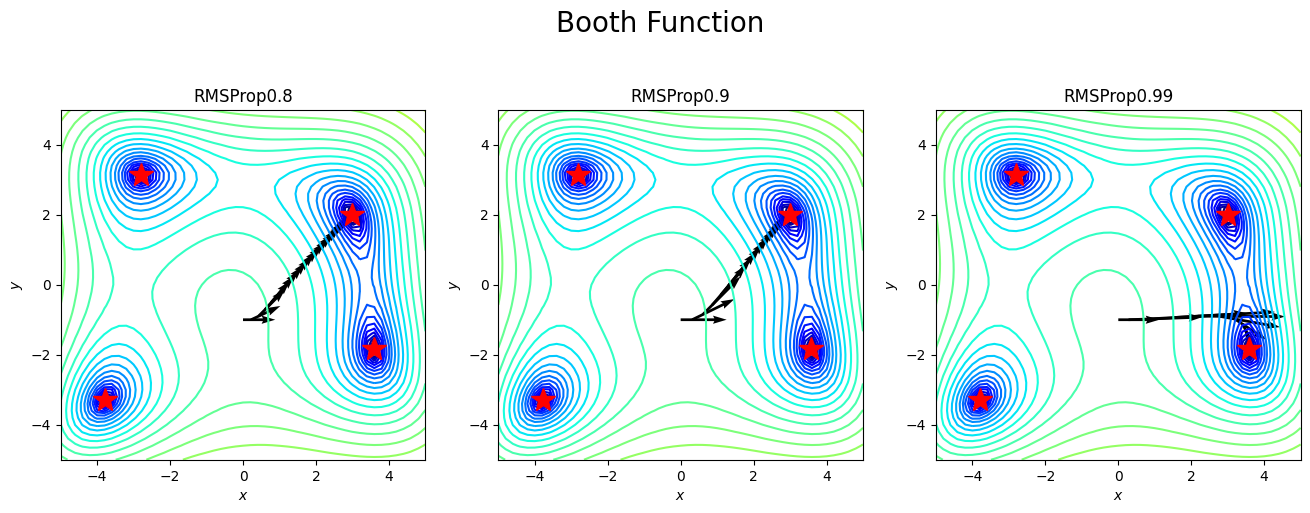

<Figure size 1200x800 with 0 Axes>

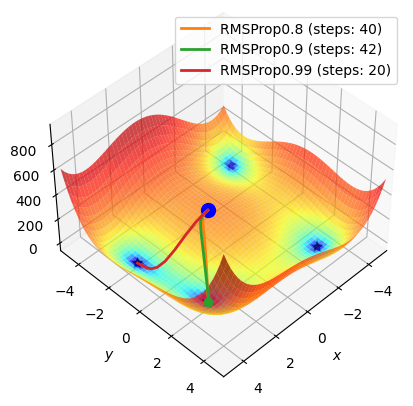

In [36]:
methods = ['RMSProp0.8','RMSProp0.9','RMSProp0.99']
optimizers = [
    RMSProp(lr=0.1,beta=0.8),
    RMSProp(lr=0.1,beta=0.9),
    RMSProp(lr=0.1,beta=0.99),
]
function1 = create_function('Booth')
function2 = create_function('Himmelblau')
max_iter=20000
max_samples_draw = 50

run(methods, function1, optimizers, max_samples_draw, max_iter, "output/rmspropbetas2d_f1.png","output/rmspropbetas3d_f1.gif")
run(methods, function2, optimizers, max_samples_draw, max_iter, "output/rmspropbetas2d_f2.png","output/rmspropbetas3d_f2.gif")
gif_to_png("output/rmspropbetas3d_f1.gif","../../../imgs/tema3/rmspropbetas_f1.png")
gif_to_png("output/rmspropbetas3d_f2.gif","../../../imgs/tema3/rmspropbetas_f2.png")

<optimizers.Adam object at 0x7f5a548f7e50> stopped in 16954 iterations
<optimizers.RMSProp object at 0x7f5a56d5fbe0> stopped in 11135 iterations
<optimizers.SGD object at 0x7f5a4dffe440> stopped in 277 iterations
Steps ['Adam (steps: 16954)', 'RMSProp (steps: 11135)', 'SGD (momentum) (steps: 277)']
sample computed for path_len=16954 is 50
sample computed for path_len=11135 is 32
len_sample_paths [52, 34, 3]
<optimizers.Adam object at 0x7f5a548f7e50> stopped in 3464 iterations
<optimizers.RMSProp object at 0x7f5a56d5fbe0> stopped in 3240 iterations
<optimizers.SGD object at 0x7f5a4dffe440> stopped in 152 iterations
Steps ['Adam (steps: 3464)', 'RMSProp (steps: 3240)', 'SGD (momentum) (steps: 152)']
sample computed for path_len=3464 is 50
sample computed for path_len=3240 is 46
sample computed for path_len=152 is 2
len_sample_paths [52, 48, 3]


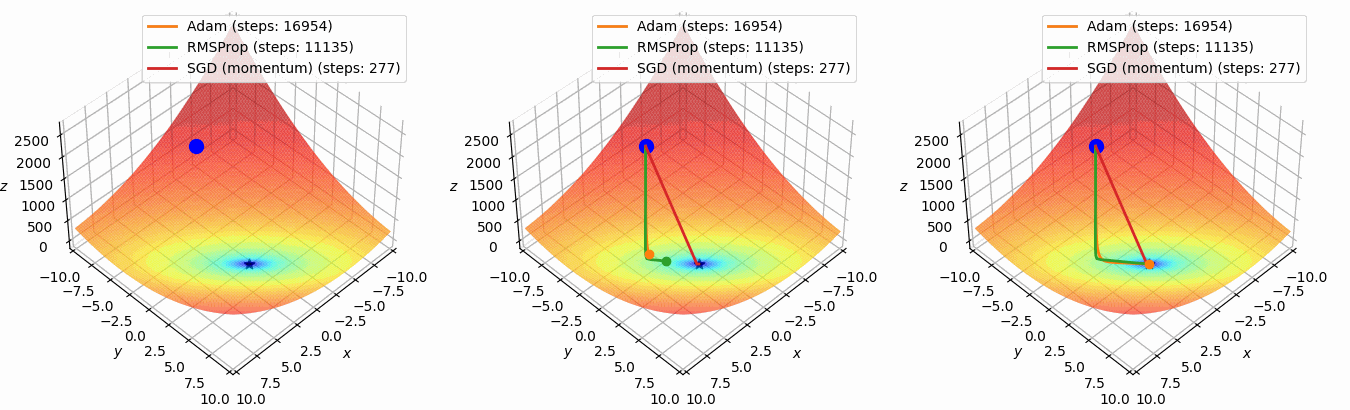

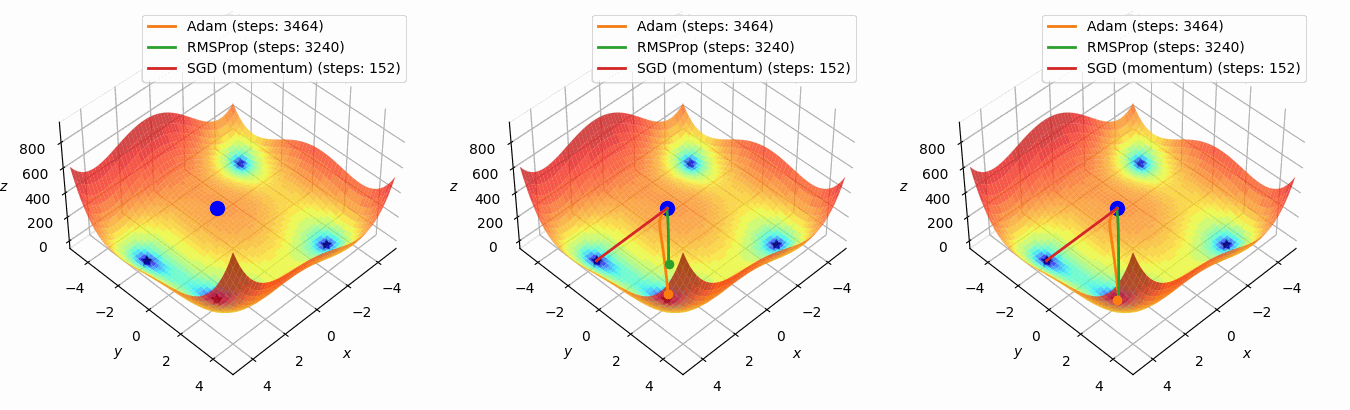

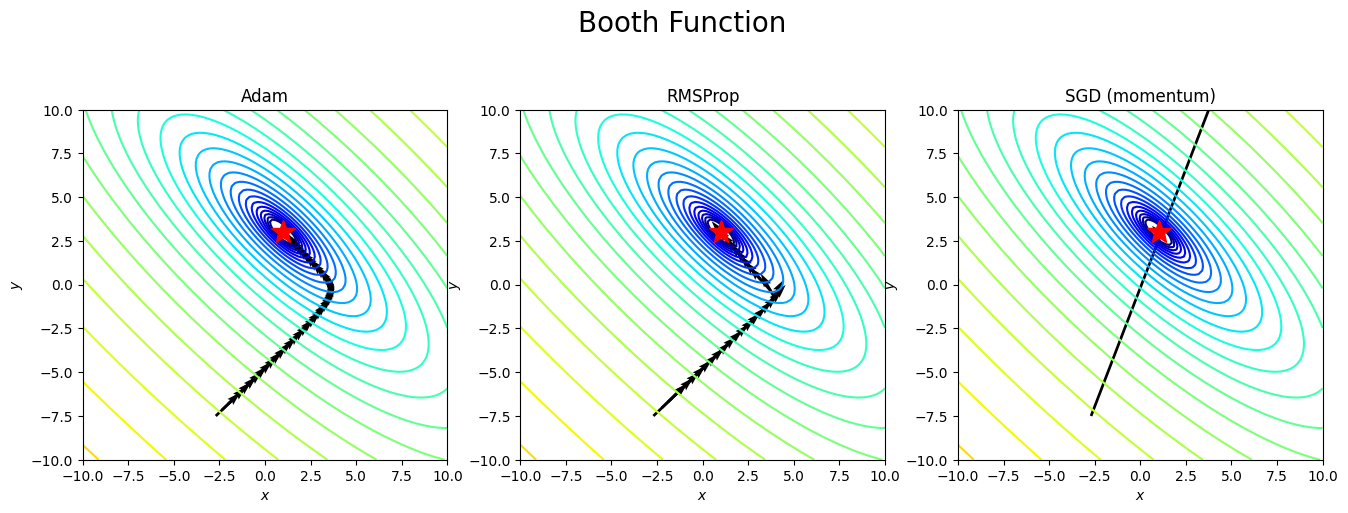

<Figure size 1200x800 with 0 Axes>

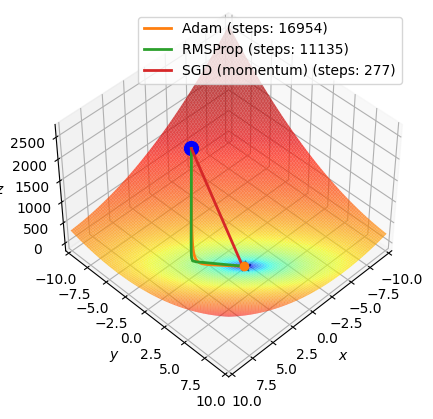

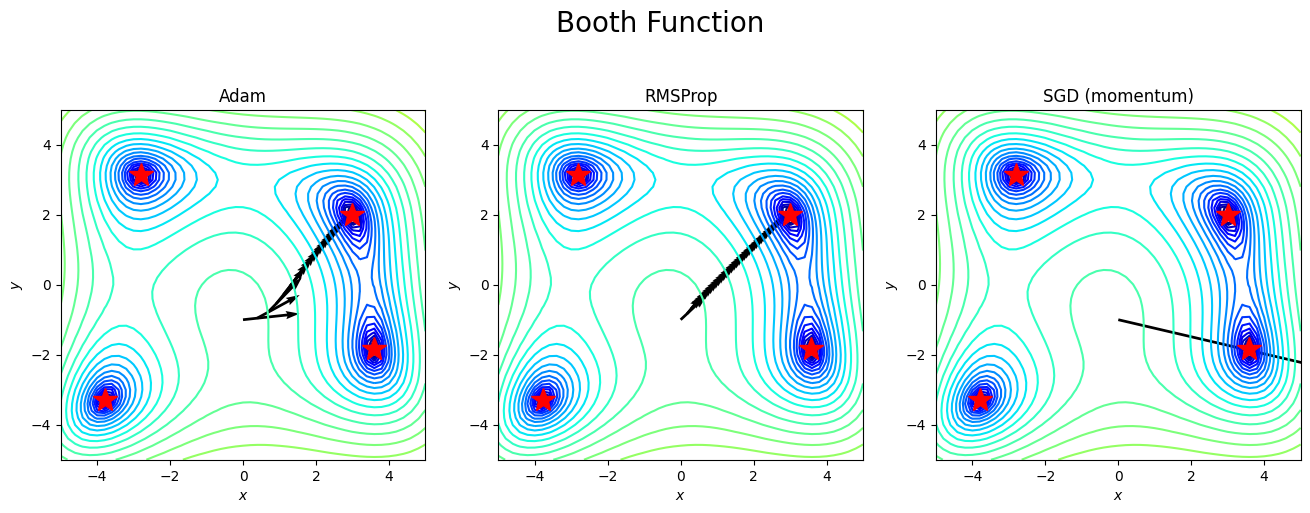

<Figure size 1200x800 with 0 Axes>

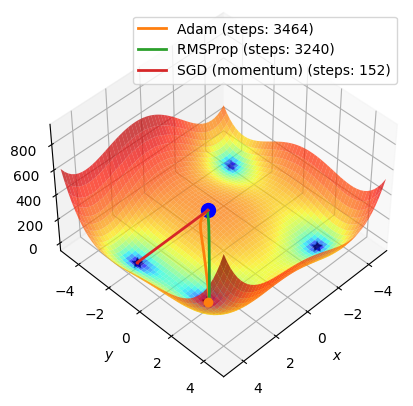

In [37]:
methods = ['Adam','RMSProp','SGD (momentum)']
optimizers = [
    Adam(lr=0.001),
    RMSProp(lr=0.001,beta=0.99),
    SGD(lr=0.001, momentum=0.9)
]
function1 = create_function('Booth')
function2 = create_function('Himmelblau')
max_iter=20000
max_samples_draw = 50

run(methods, function1, optimizers, max_samples_draw, max_iter, "output/adam2d_f1.png","output/adam3d_f1.gif")
run(methods, function2, optimizers, max_samples_draw, max_iter, "output/adam2d_f2.png","output/adam3d_f2.gif")
gif_to_png("output/adam3d_f1.gif","../../../imgs/tema3/adam_f1.png")
gif_to_png("output/adam3d_f2.gif","../../../imgs/tema3/adam_f2.png")

<optimizers.SGD object at 0x7f5a4f5b9960> stopped in 341 iterations
<optimizers.SGD object at 0x7f5a4f5baaa0> stopped in 173 iterations
<optimizers.Adagrad object at 0x7f5a4f5b8a90> stopped in 3195 iterations
<optimizers.RMSProp object at 0x7f5a4f5b8b50> stopped in 1609 iterations
<optimizers.Adam object at 0x7f5a4f5b8310> stopped in 5212 iterations
Steps ['SGD (steps: 341)', 'SGD (momentum) (steps: 173)', 'AdaGrad (steps: 3195)', 'RMSProp (steps: 1609)', 'Adam (steps: 5212)']
sample computed for path_len=341 is 6
sample computed for path_len=173 is 3
sample computed for path_len=3195 is 61
sample computed for path_len=1609 is 30
sample computed for path_len=5212 is 100
len_sample_paths [8, 5, 63, 32, 102]
<optimizers.SGD object at 0x7f5a4f5b9960> stopped in 37 iterations
<optimizers.SGD object at 0x7f5a4f5baaa0> stopped in 127 iterations
<optimizers.Adagrad object at 0x7f5a4f5b8a90> stopped in 404 iterations
<optimizers.RMSProp object at 0x7f5a4f5b8b50> stopped in 385 iterations
<opti

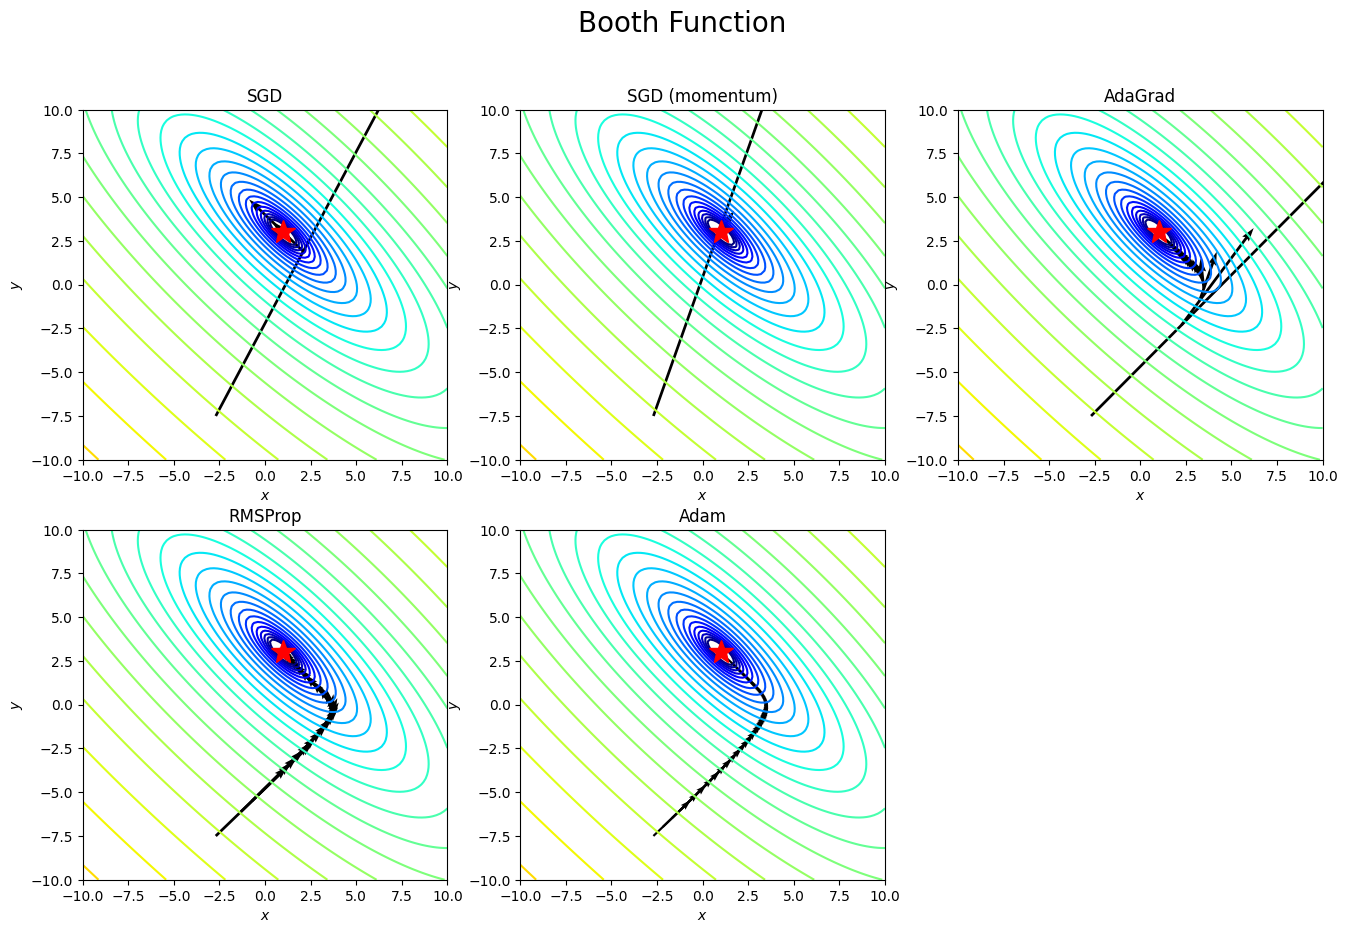

<Figure size 1200x800 with 0 Axes>

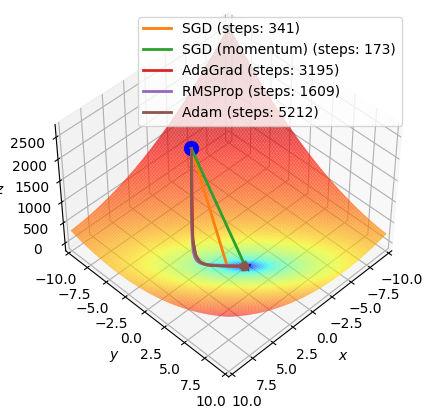

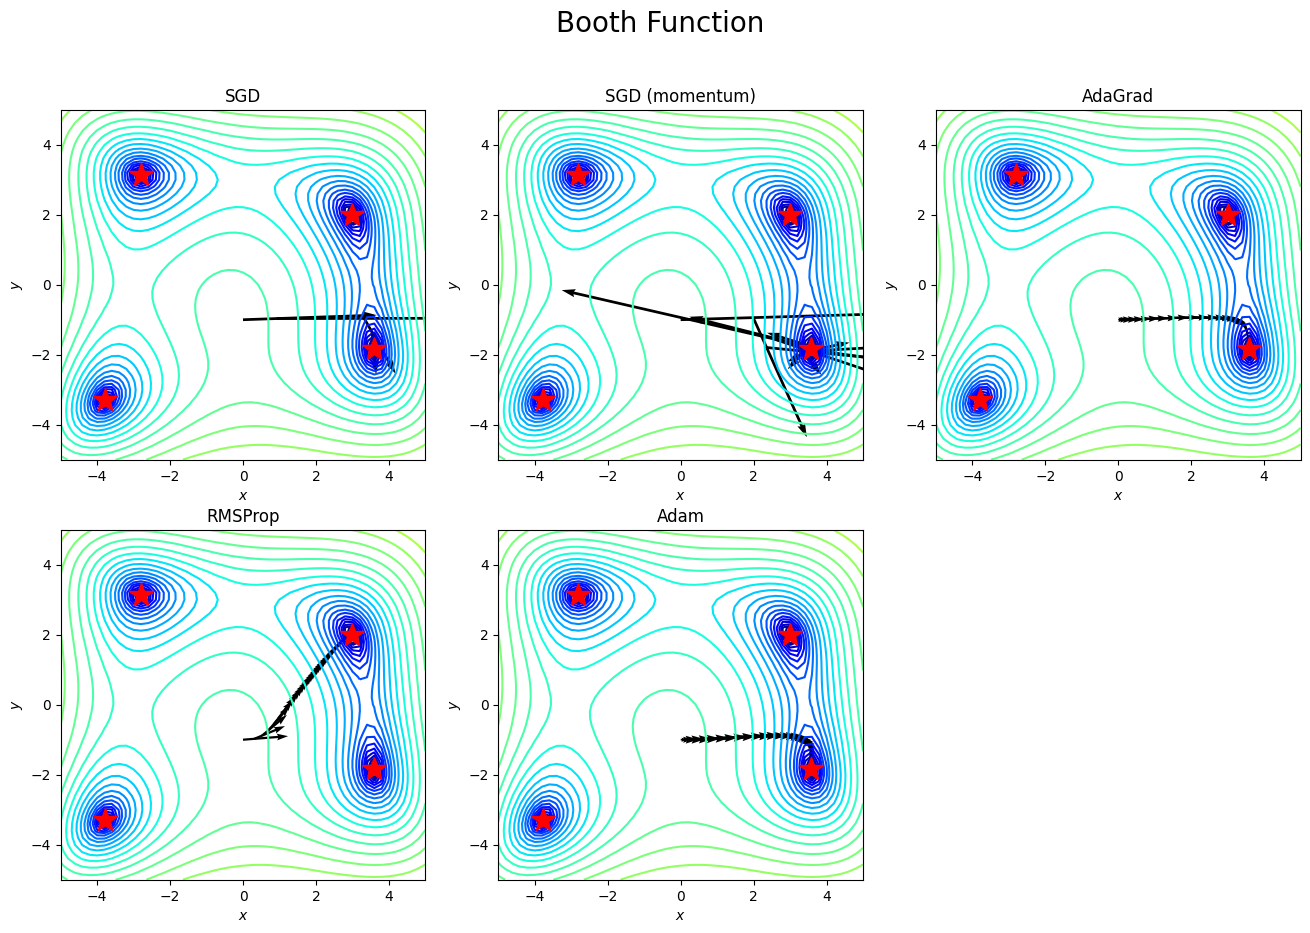

<Figure size 1200x800 with 0 Axes>

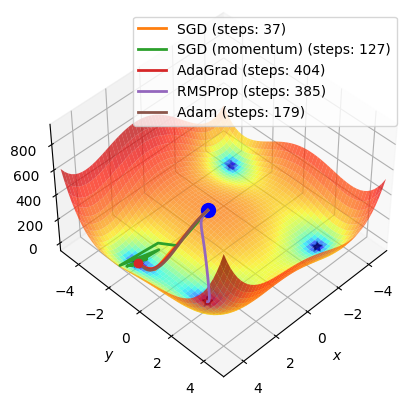

In [40]:
methods = ['SGD','SGD (momentum)','AdaGrad','RMSProp','Adam']
optimizers = [
    SGD(lr=0.01),
    SGD(lr=0.01, momentum=0.9),
    Adagrad(lr=0.5),
    RMSProp(lr=0.01,beta=0.99),
    Adam(lr=0.01)
]
function1 = create_function('Booth')
function2 = create_function('Himmelblau')

max_iter=20000
max_samples_draw = 100

run(methods, function1, optimizers, max_samples_draw, max_iter, "output/all_f1.png","output/all_f1.mp4",gif=False)
run(methods, function2, optimizers, max_samples_draw, max_iter, "output/all_f2.png","output/all_f2.mp4",gif=False)